In [ ]:
!git clone https://gitlab.com/lambda-hse/gans_coursera_public
%cd gans_coursera_public
from grading import Grader
parts = ['G92ae']
grader = Grader('Sli2Cga0QQWyL3aCpdu64Q', parts)
COURSERA_EMAIL, COURSERA_TOKEN = ???, ??? # PASTE YOUR COURSERA EMAIL AND ASSIGNMENT TOKEN HERE

Cloning into 'gans_coursera_public'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 52 (delta 8), reused 45 (delta 6), pack-reused 0
Unpacking objects: 100% (52/52), done.
/content/gans_coursera_public


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"}) # Download Celeba dataset
downloaded.GetContentFile('img_align_celeba.zip')
!unzip img_align_celeba.zip > /dev/null


# Data
CelebA [dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) will be used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


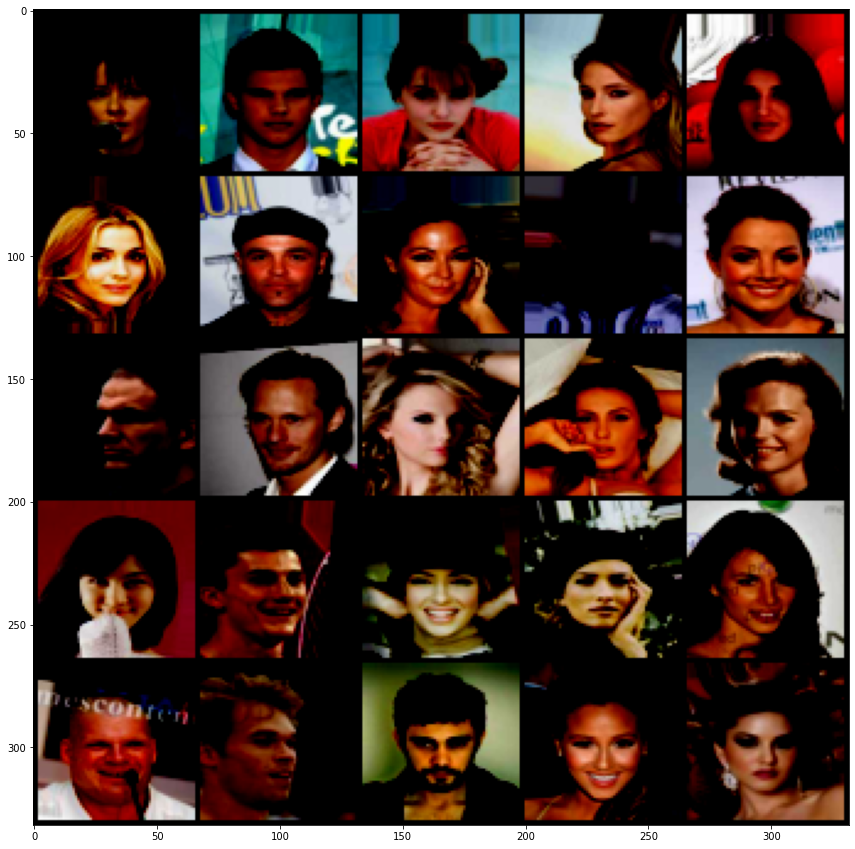

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])

# We can use torchvision package to get MNIST dataset

CELEBA_PATH = "./img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img




full_dataset = CelebA(CELEBA_PATH, transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True)

from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

# Variational Auto Encoder (VAE)

## Problem

Latent space is not completely covered by standard autoencoders (irregularity problem)

![](https://miro.medium.com/max/1000/1*83S0T8IEJyudR_I5rI9now@2x.png)

## Solution

Lets learn posterior distribution of z given x: $p(z|x)$ instead of pointwise estimation of z

## Problem 2

How to fit $p(z|x)$? Originally we can only make a suggestion about prior $p(z)$ (it can be $\mathcal{N}(0,1)$, for instance)

## Solution

Lets approximate $p(z|x)$ with neural network $q_x(z)$:

![](https://miro.medium.com/max/700/1*j9goPhh0meH884uGL70Aqg@2x.png)

$q_x(z)$ can be fitted to $p(z|x)$ by KL-divergence minimization:

![](https://miro.medium.com/max/700/1*v56YF5KqZk35r85EZBZuAQ@2x.png)

In [ ]:
# The code is taken from https://github.com/ku2482/vae.pytorch

class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = ??? # YOUR CODE HERE
        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = ??? # YOUR CODE HERE
        self.logvar = ??? # YOUR CODE HERE

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        ### hint 1: sample has the same shape and logvar and mu variables
        ### hint 2: logvar is diagonal
        ??? # YOUR CODE HERE

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Calculate mean and (log)variance
        mean, logvar = ???, ??? # YOUR CODE HERE
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder = ??? # YOUR CODE HERE

    def forward(self, input):
        output = ??? # YOUR CODE HERE
        return output # reconstructed image

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = ??? # YOUR CODE HERE
        # Decoder
        self.decoder = ??? # YOUR CODE HERE

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar

    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        ### hint 1: sample has the same shape and logvar and mu variables
        ### hint 2: logvar is diagonal
        ??? # YOUR CODE HERE

    def sample(self, size):
        # generate random sample z from prior p(z) and pass through the decoder. It will be your new generated sample
        ??? # YOUR CODE HERE

    @property
    def device(self): return next(self.parameters()).device

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Fit VAE
Implement variational autoencoder (VAE)

**Hint 1**:
$$L = \int_zq(z)log(p(x|\Theta,z))dz - KL(q(z)||p(z))$$
**Hint 2**:

$$p(z)=\mathcal{N}(0,1)$$

$$q(z)=\mathcal{N}(\mu_1,\Sigma_1)$$

$\Sigma_1$ is diagonal!

$$\mathcal{D}[\mathcal{N}(\mu_0, \Sigma_0)||\mathcal{N}(\mu_1, \Sigma_1)] = \frac{1}{2}\big(tr(\Sigma_1^{-1}\Sigma_0)+(\mu_1-\mu_0)^T\Sigma_1^{-1}(\mu_1-\mu_0)-k+\log(\frac{\det\Sigma_1}{\det\Sigma_0})\big)$$
(k-dimensionality)


In [ ]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = ??? # YOUR CODE HERE (reconstruction loss)
    KLD = ??? # KL between q(z) and p(z)
    return MSE, KLD

log_interval=10
epochs=10


def train(pbar):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in enumerate(dataloader):
        ??? # YOUR CODE HERE
        recon_batch, mu, logvar = ??? # YOUR CODE HERE
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        ??? # YOUR CODE HERE
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
  for epoch in range(1, epochs + 1):
      train(pbar)
      with torch.no_grad():
          sample = model.sample(64).cpu()
          log_img = make_grid(sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


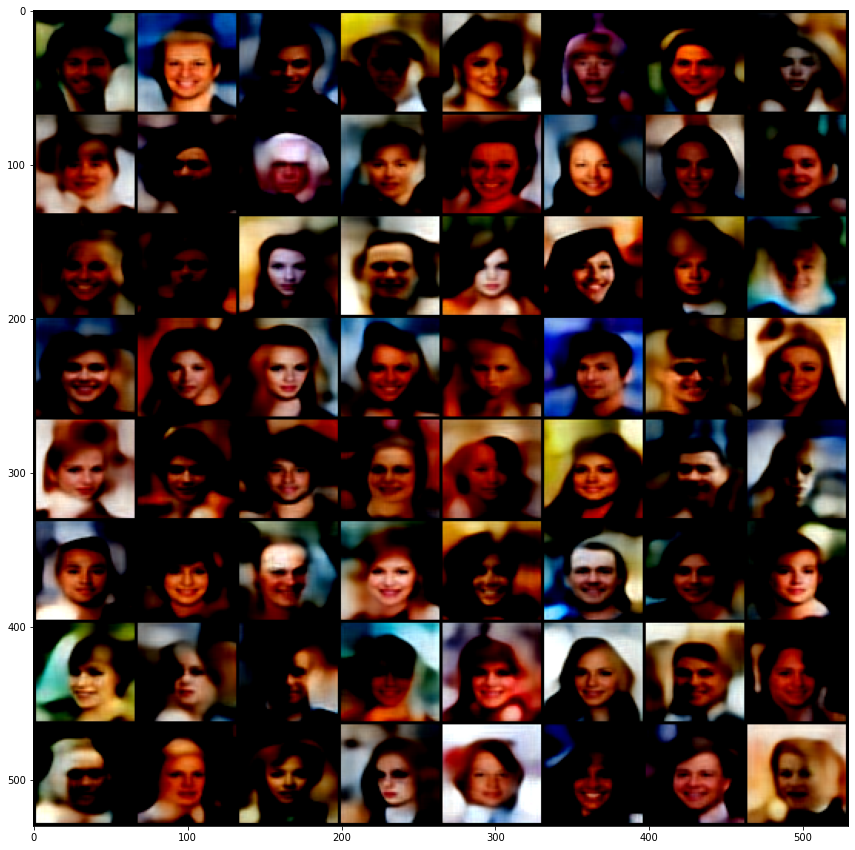

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

In [ ]:
!pip install lpips

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


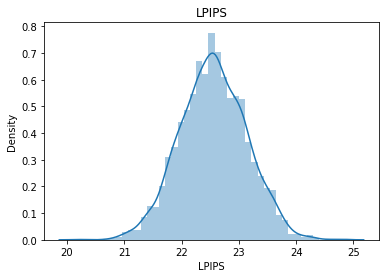

In [ ]:
# GRADED PART! DO NOT CHANGE!!!
import lpips
from tqdm.notebook import tqdm
import seaborn as sns

# define as a criterion module (recommended)
criterion = lpips.LPIPS(net='alex') # choose a network type from ['alex', 'squeeze', 'vgg']

dists = []
with torch.no_grad():
  for batch_idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch_size = data.shape[0]
        sample = model.sample(batch_size).cpu()
        dist = criterion(sample, data).squeeze().item()
        dists.append(dist)

print(dists[:5])
if np.mean(dists)>28:
  print('try again np.mean(dists) is too big')
else:
  print('mean = ', np.mean(dists))

  plt.title('LPIPS')
  plt.xlabel('LPIPS')
  sns.barplot(dists, color = 'pink')

In [ ]:
grader.set_answer(parts[0], np.mean(dists)) # Mean LPIPS must be less than 28
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

# Links
* simple explanation - [towardsds](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

* ELBO inference - [link](https://chrisorm.github.io/VI-ELBO.html)

Week 3 - VAE extra materials

https://github.com/AntixK/PyTorch-VAE

https://keras.io/examples/generative/vae/

https://www.tensorflow.org/tutorials/generative/cvae?hl=ru